In [10]:
import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import csv
import numpy as np
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from PIL import Image
from vis.utils import utils
from keras import activations
from vis.visualization import visualize_saliency, overlay
%matplotlib inline
from matplotlib import cm
from vis.visualization import visualize_cam
from keras import backend as K
from scipy.misc import imsave
import time

### load training data

In [6]:
x_train = [] # [ [len 2304], [len 2304], [len 2304] ]
y_train = [] # [ y1, y2, y3]
with open('deepq_upload/train.csv', 'rt', encoding='big5') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    row1 = next(reader) # skip headings
    for idx, row in enumerate(reader):
        img_data = [int(i) for i in row[1].split(' ')]
        x_train.append(img_data)
        y_train.append(int(row[0]))

x_train = np.array(x_train)
y_train = np.array(y_train)

img_rows, img_cols = 48, 48
num_classes = 7
input_shape = (img_rows, img_cols, 1)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_train /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)

print(x_train.shape)
print(y_train.shape)

(28709, 48, 48, 1)
(28709, 7)


In [30]:
print(x_train.shape)

(28709, 48, 48, 1)


In [12]:
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)

In [ ]:
print(x_train[0])

### train model

In [18]:
batch_size = 128
epochs = 200

model = Sequential()

model.add(Dense(112, activation='relu', input_shape=(48*48,)))
model.add(Dropout(0.25))
model.add(Dense(112, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(112, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
for_tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=batch_size,\
                                              write_graph=True,\
                                              write_grads=False, write_images=False, embeddings_freq=0,\
                                              embeddings_layer_names=None, embeddings_metadata=None)

model.fit(x = x_train,
        y = y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_split=0.1,
        callbacks=[for_tensorboard]) # validation data is not shuffled each time
'''score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])'''

Train on 25838 samples, validate on 2871 samples
Epoch 1/200
25838/25838 [==============================] - 2s - loss: 1.8910 - acc: 0.2174 - val_loss: 1.8421 - val_acc: 0.2483
Epoch 2/200
25838/25838 [==============================] - 2s - loss: 1.8360 - acc: 0.2453 - val_loss: 1.8142 - val_acc: 0.2483
Epoch 3/200
25838/25838 [==============================] - 2s - loss: 1.8245 - acc: 0.2472 - val_loss: 1.8117 - val_acc: 0.2483
Epoch 4/200
25838/25838 [==============================] - 2s - loss: 1.8162 - acc: 0.2492 - val_loss: 1.7982 - val_acc: 0.2483
Epoch 5/200
25838/25838 [==============================] - 2s - loss: 1.8069 - acc: 0.2519 - val_loss: 1.7806 - val_acc: 0.2483
Epoch 6/200
25838/25838 [==============================] - 2s - loss: 1.8046 - acc: 0.2498 - val_loss: 1.7754 - val_acc: 0.2483
Epoch 7/200
25838/25838 [==============================] - 2s - loss: 1.7968 - acc: 0.2522 - val_loss: 1.7708 - val_acc: 0.2483
Epoch 8/200
25838/25838 [==============================

"score = model.evaluate(x_test, y_test, verbose=0)\nprint('Test loss:', score[0])\nprint('Test accuracy:', score[1])"

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'x_test' is not defined

## read test data

In [4]:
x_submission = []

with open('data/test.csv', 'rt', encoding='big5') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    row1 = next(reader) # skip headings
    for idx, row in enumerate(reader):
        img_data = [int(i) for i in row[1].split(' ')]
        x_submission.append(img_data)

x_submission = np.array(x_submission)
x_submission = x_submission.reshape(x_submission.shape[0], img_rows, img_cols, 1)
print('new shape', x_submission.shape)
x_submission = x_submission.astype('float32')
x_submission /= 255

new shape (7178, 48, 48, 1)


## load model and generate predictions

In [87]:
loaded_model = keras.models.load_model('200.hdf5') # current best is 200.hdf5 (passed simple baseline)
print('loaded model!')

loaded model!


In [21]:
plot_model(model, to_file='model_ff_pic.png', show_shapes=True)

In [ ]:
pred = loaded_model.predict(x_submission, batch_size=1)
pred_to_category_num = [np.argmax(i) for i in pred]
print('generated test predictions!')

In [32]:
pred = loaded_model.predict(x_train[-2871:], batch_size=1)
pred_to_category_num = [np.argmax(i) for i in pred]
print('generated valid predictions!')

generated valid predictions!


## visualizing filters

In [34]:
img_width = 48
img_height = 48

In [3]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [89]:
loaded_model.layers = [loaded_model.layers[i] for i in [0,1,2,4,5,7,8,10,11,13,15,17]]

In [170]:
loaded_model.layers

In [91]:
layer_dict = dict([(layer.name, layer) for layer in loaded_model.layers])

In [171]:
layer_dict

{'conv2d_1': <keras.layers.convolutional.Conv2D at 0x125fa5630>,
 'conv2d_2': <keras.layers.convolutional.Conv2D at 0x126016fd0>,
 'conv2d_3': <keras.layers.convolutional.Conv2D at 0x126016908>,
 'conv2d_4': <keras.layers.convolutional.Conv2D at 0x11cb9a6a0>,
 'dense_1': <keras.layers.core.Dense at 0x12e9cf898>,
 'dense_2': <keras.layers.core.Dense at 0x115b13e80>,
 'dense_3': <keras.layers.core.Dense at 0x12e983eb8>,
 'dense_4': <keras.layers.core.Dense at 0x1233885c0>,
 'flatten_1': <keras.layers.core.Flatten at 0x125ffee48>,
 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x125fb4eb8>,
 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x126034f28>,
 'max_pooling2d_3': <keras.layers.pooling.MaxPooling2D at 0x12ed6cda0>}

In [281]:
layer_dict['conv2d_4'].output[:,:,:,0]

<tf.Tensor 'strided_slice_1247:0' shape=(?, 8, 8) dtype=float32>

In [51]:
loaded_model.input

<tf.Tensor 'conv2d_1_input:0' shape=(?, 48, 48, 1) dtype=float32>

## generate heatmap of convolution filters

In [353]:
input_img = loaded_model.input # this is just defining the layer to calculate gradients
layer_name = 'conv2d_2'
num_filters = 64

kept_filters = []
for filter_index in range(num_filters): # cannot exceed the number of filters in the layer
    
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        # loss = K.mean(layer_output[:, :, :, filter_index])
        loss = K.mean(layer_output[:,:,:, filter_index]) ############# CAREFUL, THIS HAS TO BE RIGHT!

    # this function returns the loss given the input picture
    iterate = K.function([input_img], [layer_output[:,:,:, filter_index], loss])

    # this is the real input image!
    # we start from a gray image with some random noise

    output, loss_value = iterate([input_img_data]) # output is of shape (1, n, n)
    print('Current loss value:', loss_value)

    # do we need to call deprocess_image() ?
    img = output[0] #deprocess_image(input_img_data[0])
    kept_filters.append(img)
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 0.115189
Filter 0 processed in 3s
Processing filter 1
Current loss value: 0.838343
Filter 1 processed in 3s
Processing filter 2
Current loss value: 8.78525
Filter 2 processed in 1s
Processing filter 3
Current loss value: 2.20474
Filter 3 processed in 1s
Processing filter 4
Current loss value: 0.375726
Filter 4 processed in 2s
Processing filter 5
Current loss value: 0.939074
Filter 5 processed in 1s
Processing filter 6
Current loss value: 1.37789
Filter 6 processed in 2s
Processing filter 7
Current loss value: 0.0
Filter 7 processed in 1s
Processing filter 8
Current loss value: 1.09898
Filter 8 processed in 1s
Processing filter 9
Current loss value: 2.24141
Filter 9 processed in 2s
Processing filter 10
Current loss value: 0.115992
Filter 10 processed in 2s
Processing filter 11
Current loss value: 1.42927
Filter 11 processed in 1s
Processing filter 12
Current loss value: 3.04143
Filter 12 processed in 1s
Processing filter 13
Current loss value: 0.0

In [354]:
print(np.array(kept_filters).shape[2])

44


In [356]:
# we will stitch the best n^2 filters on a n x n grid.
n = 8
img_width = np.array(kept_filters).shape[2]
img_height = np.array(kept_filters).shape[2]
brighten = 100

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.ones((width, height), dtype=np.uint8) * 255

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = np.array(kept_filters[i * n + j], dtype=np.uint8) + brighten # deprocess_image(kept_filters[i * n + j])
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height] = img


# save the result to disk
imsave('filter_outputs_%s_bright%d_%dx%d.png' % (layer_name, brighten, n, n), stitched_filters)

'''for i in range(num_filters):
    img, loss = kept_filters[i]
    imsave('conv2d_1_v3_filter_%s.png' % (i+8), img[:,:,0])'''

"for i in range(num_filters):\n    img, loss = kept_filters[i]\n    imsave('conv2d_1_v3_filter_%s.png' % (i+8), img[:,:,0])"

In [345]:
imsave('all_200.png', np.ones((100, 100), dtype=np.uint8) * 200)

In [336]:
kept_filters[0].shape

(8, 8)

## perform gradient ascent on input image (can be initialized with real image)

In [231]:
input_img_data = utils.load_img('joy2.jpg', target_size=(48, 48, 1))
input_img_data = np.array(input_img_data).reshape((1,48,48,1))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [197]:
input_img = loaded_model.input # this is just defining the layer to calculate gradients
layer_name = 'conv2d_1'
num_filters = 25

kept_filters = []
for filter_index in range(num_filters): # cannot exceed the number of filters in the layer
    
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        # loss = K.mean(layer_output[:, :, :, filter_index])
        loss = K.mean(layer_output[:,:,:, filter_index]) ############# CAREFUL, THIS HAS TO BE RIGHT!

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads) # self-defined function

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 0.01

    # this is the real input image!
    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 1, 48, 48))
    else:
        input_img_data = np.random.random((1, 48, 48, 1)) # I suppose this means input is only one image
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent
    for i in range(2000):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data = input_img_data + grads_value * step

        if i % 400 == 399:
            print('Current loss value:', loss_value)
        '''if loss_value <= 0.: # my activation is ReLU, output of layer cannot be < 0?
            # some filters get stuck to 0, we can skip them
            # but what if gradient can take loss to positive value?
            break'''
        
        '''if loss_value == 1.0:
            print('reached 1.0!')
            break'''

    # decode the resulting input image
    if True: # loss_value > 0
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 3.08874
Current loss value: 4.23412
Current loss value: 5.43089
Current loss value: 6.66181
Current loss value: 7.91759
Filter 0 processed in 5s
Processing filter 1
Current loss value: 2.31214
Current loss value: 3.16363
Current loss value: 4.03991
Current loss value: 4.93399
Current loss value: 5.84112
Filter 1 processed in 4s
Processing filter 2
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0.0
Filter 2 processed in 4s
Processing filter 3
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0.0
Filter 3 processed in 4s
Processing filter 4
Current loss value: 0.400945
Current loss value: 0.882913
Current loss value: 1.45441
Current loss value: 2.08355
Current loss value: 2.75878
Filter 4 processed in 4s
Processing filter 5
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0.0
Current loss value: 0

In [198]:
# we will stitch the best n^2 filters on a n x n grid.
n = 5

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]
print(len(kept_filters))

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img


# save the result to disk
imsave('stitched_filters_smallerrate_%s_%dx%d.png' % (layer_name, n, n), stitched_filters)

'''for i in range(num_filters):
    img, loss = kept_filters[i]
    imsave('conv2d_1_v3_filter_%s.png' % (i+8), img[:,:,0])'''

25


"for i in range(num_filters):\n    img, loss = kept_filters[i]\n    imsave('conv2d_1_v3_filter_%s.png' % (i+8), img[:,:,0])"

## saliency map

#### choose image to see saliency

In [347]:
img_id = 110

img = Image.new('L', (img_rows, img_cols))
pixelsNew = img.load()
for i in range(len(x_train[img_id])): # cols, WTF?
    for j in range(len(x_train[img_id][i])): # rows
        pixelsNew[j,i] = int(x_train[img_id][i][j][0] * 256)
img.show()
classes = ['angry', 'hate', 'fear', 'joy', 'sad', 'surprise', 'neutral']
print(classes[np.argmax(y_train[img_id])])

fear


In [348]:
img.save('fear2.jpg')

#### begin setting up saliency map

In [116]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(loaded_model, 'predictions')

# Swap softmax with linear
loaded_model.layers[-1].activation = activations.linear
loaded_model = utils.apply_modifications(loaded_model)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


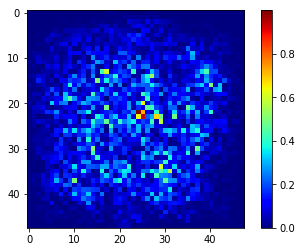

In [349]:
img1 = utils.load_img('fear2.jpg', target_size=(48, 48, 1))
grads = visualize_saliency(loaded_model, -1, filter_indices=None, seed_input=img1) # grads is a 'jet' image
grads_norm = utils.normalize(grads)
# visualize grads as heatmap
plt.imshow(grads_norm, cmap='jet')
plt.colorbar() # this bar is independent from grads, merely the 'jet' scheme bar

#### see which rgb values to cut based on trying jet(scalar vals)

In [284]:
# plt.imshow(np.random.rand(10,10), 'jet')
np.array(list(cm.jet(0.3))[0:3]) * 256

array([   0.  ,  177.19,  256.  ])

In [350]:
img_cut = Image.new('L', (img_rows, img_cols))
pixelsNew = img_cut.load()
for i in range(len(grads)): # cols, WTF?
    for j in range(len(grads[i])): # rows
        if grads[i][j][1] > 177:
            pixelsNew[j,i] = int(x_train[img_id][i][j][0] * 256)
img_cut.show()
# img_cut.save('cut.jpg')

## confusion matrix

Normalized confusion matrix
[[ 0.52  0.    0.1   0.05  0.22  0.01  0.09]
 [ 0.59  0.    0.15  0.03  0.21  0.03  0.  ]
 [ 0.13  0.    0.34  0.05  0.28  0.1   0.09]
 [ 0.01  0.    0.02  0.87  0.04  0.01  0.05]
 [ 0.07  0.    0.05  0.06  0.64  0.    0.18]
 [ 0.02  0.    0.15  0.06  0.03  0.7   0.04]
 [ 0.04  0.    0.04  0.09  0.26  0.01  0.57]]


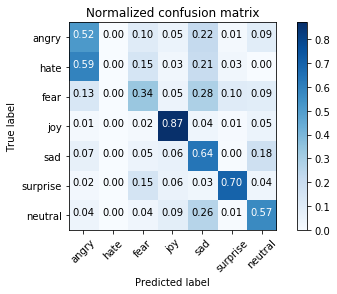

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix([np.argmax(i) for i in y_train[-2871:]], pred_to_category_num)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['angry', 'hate', 'fear', 'joy', 'sad', 'surprise', 'neutral'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## write submission file

In [58]:
with open('200.csv', 'wt') as outfile:
    test_writer = csv.writer(outfile)
    test_writer.writerow(['id','label'])
    
    counter = 0
    for num in pred_to_category_num:
        test_writer.writerow([counter, num])
        counter += 1
    
print('finished writing submission!')

finished writing submission!


In [79]:
model.save('CNN_dsafadsf.h5')